<a href="https://colab.research.google.com/github/ArnaudOlt/dissertation_pybamm/blob/main/3_1_reversible_li_plt_loss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pip install pybtex
%pip install anytree
%pip install autograd
%pip install bpx
%pip install casadi
%pip install imageio
%pip install importlib-metadata
%pip install matplotlib
%pip install numpy
%pip install pandas
%pip install scikit-fem
%pip install scipy
%pip install sympy
%pip install tqdm
%pip install xarray
%pip install git+https://github.com/pybamm-team/pybamm.git@develop
import pybamm
import numpy as np
import matplotlib.pyplot as plt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 561.4/561.4 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.5/67.5 MB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.1/160.1 kB 3.5 MB/s eta 0:00:00
  Cloning https://github.com/pybamm-team/pybamm.git (to revision develop) to /tmp/pip-req-build-9loua9d9
  Running command git clone --filter=blob:none --quiet https://github.com/pybamm-team/pybamm.git /tmp/pip-req-build-9loua9d9
  Resolved https://github.com/pybamm-team/pybamm.git to commit efdb04ba7edf0fc8d01846d89777eb5a3b8f195e
  Preparing metadata (setup.py) ... done
  Created wheel for pybamm: filename=pybamm-23.5-py3-none-any.whl size=1103980 sha256=356e43de2cf06a3d92883de8f4fdfefd62e41261c6230fe5d1591c89d0311396
  Stored in directory: /tmp/pip-ephem-wheel-cache-ihueysil/wheels/86/5d/c0/01117b8a9a462c9838f1ca559e2d7b3b02536b4dd61d787fa3
Successfully built pybamm


In [ ]:
li_plt_model = pybamm.lithium_ion.SPMe(
    {
        "lithium plating": "partially reversible",
        "lithium plating porosity change": "true",  # alias for "SEI porosity change"
    }
)

In [ ]:
prada2013_params = pybamm.ParameterValues("Prada2013")

def plating_exchange_current_density_OKane2020(c_e, c_Li, T):
    """
    Exchange-current density for Li plating reaction [A.m-2].
    References
    ----------
    .. [1] O’Kane, Simon EJ, Ian D. Campbell, Mohamed WJ Marzook, Gregory J. Offer, and
    Monica Marinescu. "Physical origin of the differential voltage minimum associated
    with lithium plating in Li-ion batteries." Journal of The Electrochemical Society
    167, no. 9 (2020): 090540.
    Parameters
    ----------
    c_e : :class:`pybamm.Symbol`
        Electrolyte concentration [mol.m-3]
    c_Li : :class:`pybamm.Symbol`
        Plated lithium concentration [mol.m-3]
    T : :class:`pybamm.Symbol`
        Temperature [K]
    Returns
    -------
    :class:`pybamm.Symbol`
        Exchange-current density [A.m-2]
    """

    k_plating = pybamm.Parameter("Lithium plating kinetic rate constant [m.s-1]")

    return pybamm.constants.F * k_plating * c_e


def stripping_exchange_current_density_OKane2020(c_e, c_Li, T):
    """
    Exchange-current density for Li stripping reaction [A.m-2].

    References
    ----------

    .. [1] O’Kane, Simon EJ, Ian D. Campbell, Mohamed WJ Marzook, Gregory J. Offer, and
    Monica Marinescu. "Physical origin of the differential voltage minimum associated
    with lithium plating in Li-ion batteries." Journal of The Electrochemical Society
    167, no. 9 (2020): 090540.

    Parameters
    ----------

    c_e : :class:`pybamm.Symbol`
        Electrolyte concentration [mol.m-3]
    c_Li : :class:`pybamm.Symbol`
        Plated lithium concentration [mol.m-3]
    T : :class:`pybamm.Symbol`
        Temperature [K]

    Returns
    -------

    :class:`pybamm.Symbol`
        Exchange-current density [A.m-2]
    """

    k_plating = pybamm.Parameter("Lithium plating kinetic rate constant [m.s-1]")

    return pybamm.constants.F * k_plating * c_Li

def SEI_limited_dead_lithium_OKane2022(L_sei):
    """
    Decay rate for dead lithium formation [s-1].
    References
    ----------
    .. [1] Simon E. J. O'Kane, Weilong Ai, Ganesh Madabattula, Diega Alonso-Alvarez,
    Robert Timms, Valentin Sulzer, Jaqueline Sophie Edge, Billy Wu, Gregory J. Offer
    and Monica Marinescu. "Lithium-ion battery degradation: how to model it."
    Physical Chemistry: Chemical Physics 24, no. 13 (2022): 7909-7922.
    Parameters
    ----------
    L_sei : :class:`pybamm.Symbol`
        Total SEI thickness [m]
    Returns
    -------
    :class:`pybamm.Symbol`
        Dead lithium decay rate [s-1]
    """

    gamma_0 = pybamm.Parameter("Dead lithium decay constant [s-1]")
    L_inner_0 = pybamm.Parameter("Initial inner SEI thickness [m]")
    L_outer_0 = pybamm.Parameter("Initial outer SEI thickness [m]")
    L_sei_0 = L_inner_0 + L_outer_0

    gamma = gamma_0 * L_sei_0 / L_sei

    return gamma



prada2013_params.update({
        #experiment
        "Lower voltage cut-off [V]": 2.5,
        "Upper voltage cut-off [V]": 3.65,
        #cell
        "Negative current collector thickness [m]": 0.000006,
        "Separator thickness [m]": 0.000016,
        "Positive current collector thickness [m]": 0.000013,
        "Electrode height [m]": 0.325,
        "Electrode width [m]": 21.6,
        "Cell cooling surface area [m2]": 0.07338004,
        "Cell volume [m3]": 0.00106398976,
        "Positive current collector density [kg.m-3]": 2700,
        "Positive current collector thermal conductivity [W.m-1.K-1]": 237,
        "Nominal cell capacity [A.h]":100,
        "Current function [A]":100,
        "Contact resistance [Ohm]": 0.0004,
        #electrolyte
        "Electrolyte conductivity [S.m-1]": 0.97,



        #Okane2022 Li plating
        "Lithium metal partial molar volume [m3.mol-1]": 1.3e-05,
        "Lithium plating kinetic rate constant [m.s-1]": 1e-09,
        "Exchange-current density for plating [A.m-2]": plating_exchange_current_density_OKane2020,
        "Exchange-current density for stripping [A.m-2]": stripping_exchange_current_density_OKane2020,
        "Initial plated lithium concentration [mol.m-3]": 0.0,
        "Typical plated lithium concentration [mol.m-3]": 1000.0,
        "Lithium plating transfer coefficient": 0.65,
        "Dead lithium decay constant [s-1]": 1e-06,
        "Dead lithium decay rate [s-1]": SEI_limited_dead_lithium_OKane2022,
        #Okane2022 SEI
        "Ratio of lithium moles to SEI moles": 1.0,
        "Inner SEI reaction proportion": 0.0,
        "Inner SEI partial molar volume [m3.mol-1]": 9.585e-05,
        "Outer SEI partial molar volume [m3.mol-1]": 9.585e-05,
        "SEI reaction exchange current density [A.m-2]": 1.5e-07,
        "SEI resistivity [Ohm.m]": 200000.0,
        "Outer SEI solvent diffusivity [m2.s-1]": 2.5000000000000002e-22,
        "Bulk solvent concentration [mol.m-3]": 2636.0,
        "Inner SEI open-circuit potential [V]": 0.1,
        "Outer SEI open-circuit potential [V]": 0.8,
        "Inner SEI electron conductivity [S.m-1]": 8.95e-14,
        "Inner SEI lithium interstitial diffusivity [m2.s-1]": 1e-20,
        "Lithium interstitial reference concentration [mol.m-3]": 15.0,
        "Initial inner SEI thickness [m]": 0.0,
        "Initial outer SEI thickness [m]": 5e-09,
        "EC initial concentration in electrolyte [mol.m-3]": 4541.0,
        "EC diffusivity [m2.s-1]": 2e-18,
        "SEI kinetic rate constant [m.s-1]": 1e-12,
        "SEI open-circuit potential [V]": 0.4,
        "SEI growth activation energy [J.mol-1]": 38000.0,
        "Negative electrode reaction-driven LAM factor [m3.mol-1]": 0.0,
        "Positive electrode reaction-driven LAM factor [m3.mol-1]": 0.0

        }, check_already_exists=False)


In [ ]:
pybamm.set_logging_level("NOTICE")
cycle_number = 50
exp = pybamm.Experiment(
    [("Discharge at 1C until 2.4 V",  # ageing cycles
    "Charge at 0.3C until 3.8 V",
    "Hold at 3.8 V until C/20",
    "Rest for 4 hours",)] * cycle_number
)

In [ ]:
temperatures = [268.15, 288.15] #-5, 15°C

solutions = {} # dict, key is temp and values is solution object

for temp in temperatures:
    param = prada2013_params
    param.update({"Ambient temperature [K]": temp})

    sim = pybamm.Simulation(li_plt_model, parameter_values=param, experiment=exp)
    safe_solver = pybamm.CasadiSolver(mode="safe", dt_max=120)
    sol = sim.solve(solver=safe_solver, calc_esoh=False)
    solutions[temp] = sol


2023-09-10 18:23:14.365 - [NOTICE] callbacks.on_cycle_start(172): Cycle 1/50 (2.191 ms elapsed) --------------------
NOTICE:pybamm.logger:Cycle 1/50 (2.191 ms elapsed) --------------------
2023-09-10 18:23:14.369 - [NOTICE] callbacks.on_step_start(180): Cycle 1/50, step 1/4: Discharge at 1C until 2.4 V
NOTICE:pybamm.logger:Cycle 1/50, step 1/4: Discharge at 1C until 2.4 V
2023-09-10 18:23:14.796 - [NOTICE] callbacks.on_step_start(180): Cycle 1/50, step 2/4: Charge at 0.3C until 3.8 V
NOTICE:pybamm.logger:Cycle 1/50, step 2/4: Charge at 0.3C until 3.8 V
2023-09-10 18:23:15.561 - [NOTICE] callbacks.on_step_start(180): Cycle 1/50, step 3/4: Hold at 3.8 V until C/20
NOTICE:pybamm.logger:Cycle 1/50, step 3/4: Hold at 3.8 V until C/20
2023-09-10 18:23:16.688 - [NOTICE] callbacks.on_step_start(180): Cycle 1/50, step 4/4: Rest for 4 hours
NOTICE:pybamm.logger:Cycle 1/50, step 4/4: Rest for 4 hours
2023-09-10 18:23:18.626 - [NOTICE] callbacks.on_cycle_start(172): Cycle 2/50 (4.263 s elapsed) --

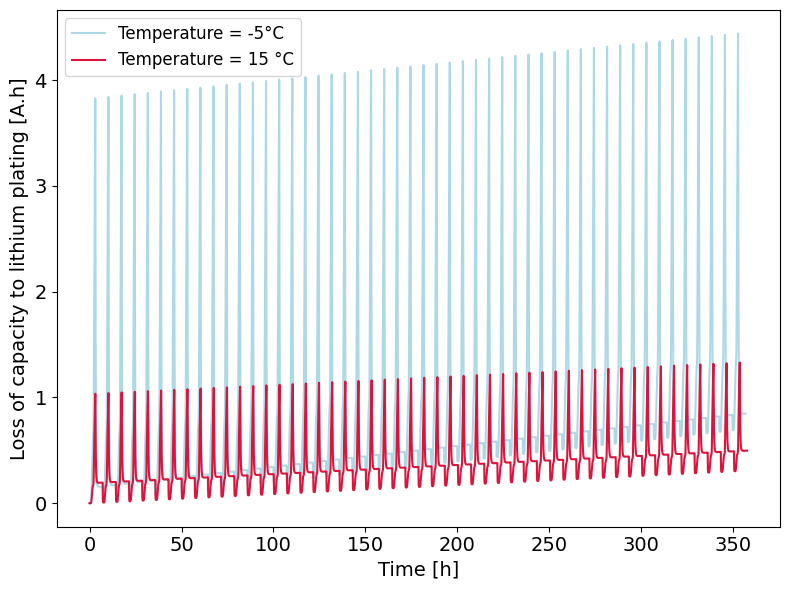

In [ ]:
import matplotlib.pyplot as plt

# Create param_list and simulations as shown in the previous responses

x_axis_var_str = "Time [h]"
y_axis_var_str = "Loss of capacity to lithium plating [A.h]"

fig, ax = plt.subplots(figsize=(8, 6))

line_colors = ["lightblue", "crimson", "lightblue", "coral", "seagreen", "cyan", "magenta", "yellow"]
label_names = ["Temperature = -5°C", "Temperature = 15 °C", "Temperature = 15°C", "Temperature = 14.3 °C"]

for i, (temp, sol) in enumerate(solutions.items()):
    x_sol = sol[x_axis_var_str].entries
    y_sol = sol[y_axis_var_str].entries

    color = line_colors[i % len(line_colors)]  # Cycle through colors if needed
    label = label_names[i % len(label_names)]  # Cycle through label_names if needed
    ax.plot(x_sol, y_sol, label=label, color = color)

ax.set_xlabel(x_axis_var_str, fontsize=14)
ax.set_ylabel(y_axis_var_str, fontsize=14)


plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()

ax.legend(fontsize=12)
plt.tight_layout()
plt.show()
